In [ ]:
import numpy as np
import pandas as pd
import pulp
import itertools
import gmaps
import googlemaps
import haversine as hs

In [ ]:

API_KEY = 'API key_here from google'
gmaps.configure(api_key=API_KEY)
googlemaps = googlemaps.Client(key=API_KEY)

In [ ]:
# customer count ('0' is depot) 
customer_count = 12

# the number of vehicle
vehicle_count = 4

# the capacity of vehicle
vehicle_capacity = 50

# fix random seed
np.random.seed(seed=777)

# set depot latitude and longitude
depot_latitude = 40.748817
depot_longitude = -73.985428

# make dataframe which contains vending machine location and demand
df = pd.DataFrame({"latitude":np.random.normal(depot_latitude, 0.007, customer_count), 
                   "longitude":np.random.normal(depot_longitude, 0.007, customer_count), 
                   "demand":np.random.randint(10, 20, customer_count)})

# set the depot as the center and make demand 0 ('0' = depot)
df.iloc[0,0] = depot_latitude
df.iloc[0,1] = depot_longitude
df.iloc[0,2] = 0


In [ ]:
print(df)

     latitude  longitude  demand
0   40.748817 -73.985428       0
1   40.743057 -73.995250      15
2   40.748359 -73.989855      15
3   40.743823 -73.989340      18
4   40.755161 -73.994061      11
5   40.754181 -73.988505      14
6   40.754599 -73.979024      17
7   40.739551 -73.983573      14
8   40.736550 -73.995112      14
9   40.755834 -73.980629      10
10  40.752631 -73.982235      19
11  40.762083 -73.988658      14


In [ ]:
# function for calculating distance between two pins
def _distance_calculator(_df):
    
    distance_result = np.zeros((len(_df),len(_df)))
    #_df['latitude-longitude'] = '0'
    #for i in range(len(_df)):
        #_df['latitude-longitude'].iloc[i] = str(_df.latitude[i]) + ',' + str(_df.longitude[i])
    
    for i in range(len(_df)):
        for j in range(len(_df)):
            point_one=(_df['latitude'].iloc[i],_df['longitude'].iloc[i])
            point_two=(_df['latitude'].iloc[j],_df['longitude'].iloc[j])
            # calculate distance of all pairs
            _distance_result = hs.haversine(point_one, point_two)
            distance_result[i][j]=_distance_result                                               
    
    return distance_result

In [ ]:
distance = _distance_calculator(df)


In [ ]:
# solve with pulp
for vehicle_count in range(1,vehicle_count+1):
    
    # definition of LpProblem instance
    problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

    # definition of variables which are 0/1
    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(vehicle_count)]for j in range(customer_count)] for i in range(customer_count)]

    # add objective function
    problem += pulp.lpSum(distance[i][j] * x[i][j][k] if i != j else 0
                          for k in range(vehicle_count) 
                          for j in range(customer_count) 
                          for i in range (customer_count))

    # constraints
    # foluma (2)
    for j in range(1, customer_count):
        problem += pulp.lpSum(x[i][j][k] if i != j else 0 
                              for i in range(customer_count) 
                              for k in range(vehicle_count)) == 1 

    # foluma (3)
    for k in range(vehicle_count):
        problem += pulp.lpSum(x[0][j][k] for j in range(1,customer_count)) == 1
        problem += pulp.lpSum(x[i][0][k] for i in range(1,customer_count)) == 1

    # foluma (4)
    for k in range(vehicle_count):
        for j in range(customer_count):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0 
                                  for i in range(customer_count)) -  pulp.lpSum(x[j][i][k] for i in range(customer_count)) == 0

    #foluma (5)
    for k in range(vehicle_count):
        problem += pulp.lpSum(df.demand[j] * x[i][j][k] if i != j else 0 for i in range(customer_count) for j in range (1,customer_count)) <= vehicle_capacity 


    # fomula (6)
    subtours = []
    for i in range(2,customer_count):
         subtours += itertools.combinations(range(1,customer_count), i)

    for s in subtours:
        problem += pulp.lpSum(x[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2) for k in range(vehicle_count)) <= len(s) - 1

    
    # print vehicle_count which needed for solving problem
    # print calculated minimum distance value
    if problem.solve() == 1:
        print('Vehicle Requirements:', vehicle_count)
        print('Moving Distance:', pulp.value(problem.objective))
        break

Vehicle Requirements: 4
Moving Distance: 10.719789818047351


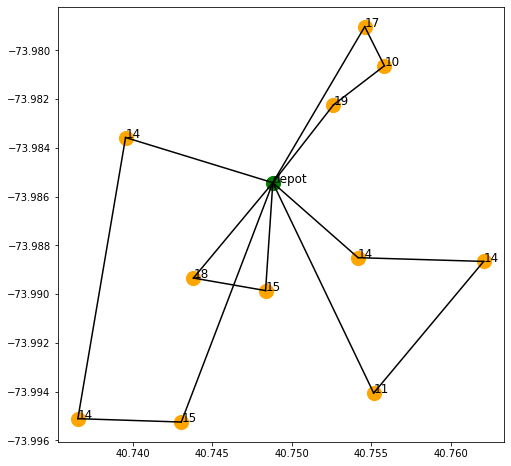

In [ ]:
# visualization : plotting with matplolib
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
for i in range(customer_count):    
    if i == 0:
        plt.scatter(df.latitude[i], df.longitude[i], c='green', s=200)
        plt.text(df.latitude[i], df.longitude[i], "depot", fontsize=12)
    else:
        plt.scatter(df.latitude[i], df.longitude[i], c='orange', s=200)
        plt.text(df.latitude[i], df.longitude[i], str(df.demand[i]), fontsize=12)

for k in range(vehicle_count):
    for i in range(customer_count):
        for j in range(customer_count):
            if i != j and pulp.value(x[i][j][k]) == 1:
                plt.plot([df.latitude[i], df.latitude[j]], [df.longitude[i], df.longitude[j]], c="black")

plt.show()